# Partie 4 du document

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import fonctionsAKM
from tqdm import tqdm

In [21]:
#On commence par fixer le nombre de docteurs et le nombre de patients 

#Le nombre de docteurs:
nombre_docteur = 10
#Le nombre de patients:
nombre_patient = 10

Dans le document on nous dit de prendre le modèle suivant :

 $D_{ij}= \mathbb{1}_{\{c + dX_{ij} + \alpha_{i} + \psi_{j} + V_{i,j}>0\}} $

 $Y_{i,j} = a + bX_{i,j} + \alpha_{i} + \psi_{j} + \epsilon_{i,j}$

 On a ici $\epsilon_{i,j} \sim \mathcal{N}(0,1)$ et $V_{i,j} \sim \mathcal{N}(0,1)$

 Pour correspondre au mieux à notre modèle, on va cependant se remettre sur la même base que dans la partie

$D_{i,j} \sim \mathcal{B}(1,\frac{e^{\lambda_{ij}}}{1+e^{\lambda_{ij}}})$ où:

 $\lambda_{ij}= c + dX_{ij} + \alpha_i + \psi_j $


In [116]:
#On s'occupe maintenant de créer les variables de notre modèle
#On se remet dans le même contexte que quand on appliquait AKM
## Ici on reprend donc juste le code de la partie AKM
a = 4
b = 3
c = 0
d = 0.2

#On commence par déterminer la position des individus sur le plan [0,1]*[0,1]
def position (n):
    return (np.random.uniform(0,1,size = (n)), np.random.uniform(0,1,size = (n)))
position_docteur = position(nombre_docteur)
position_patient = position(nombre_patient)

#On calcule la distance entre eux (notre Xij)
matrice_distance = np.zeros((nombre_patient, nombre_docteur))
for j in range(nombre_docteur):
    for i in range(nombre_patient):
        matrice_distance[i,j] = np.sqrt((position_patient[1][i]-position_docteur[1][j])**2+(position_patient[0][i]-position_docteur[0][j])**2)

#On crée les alpha_i et psi_j
alpha_d = np.random.randint(0,3,size=nombre_patient)/10
psi_d = np.random.randint(0,3,size=nombre_docteur)/10

alpha_y = np.random.randint(0,3,size=nombre_patient)
psi_y = np.random.randint(0,3,size=nombre_docteur)

#On crée les Dij
lien = np.zeros((nombre_patient,nombre_docteur))
for j in range(nombre_docteur):
    for i in range(nombre_patient):
        lambda_ij = c + d*matrice_distance[i,j]-alpha_d[i]+psi_d[j]
        lien[i,j] = np.random.binomial(1,1-(1/(1+np.exp(lambda_ij))))

#On crée ensuite les Yij
prix = np.zeros((nombre_patient,nombre_docteur))
for j in range(nombre_docteur):
    for i in range(nombre_patient):
        prix[i,j] = a + b*matrice_distance[i,j] + alpha_y[i] + psi_y[j] + np.random.normal(0,1)
        #Ici on avait pas mis la normal dans AKM, à discuter

prix_observe = prix*lien

/tmp/ipykernel_64289/1232269001.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([position_docteur[0][j], position_patient[0][i]], [position_docteur[1][j], position_patient[1][i]], 'k-',alpha=0.5,color="green")


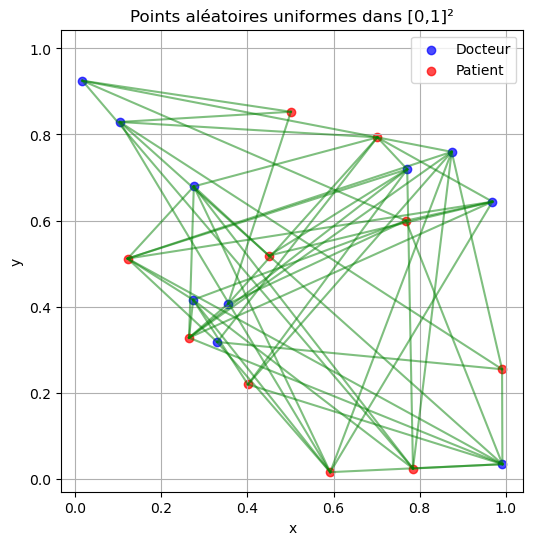

In [117]:
plt.figure(figsize=(6, 6))
plt.scatter(position_docteur[0], position_docteur[1], color='blue', alpha=0.7, label="Docteur")
plt.scatter(position_patient[0], position_patient[1], color='red', alpha=0.7, label="Patient")
for i in range(nombre_patient):
    for j in range(nombre_docteur):
        if lien[i,j] == 1:
            plt.plot([position_docteur[0][j], position_patient[0][i]], [position_docteur[1][j], position_patient[1][i]], 'k-',alpha=0.5,color="green")
plt.title("Points aléatoires uniformes dans [0,1]²")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

In [118]:
#On effectue maintenant la "two-step method"

#Commençons par l'étape de classification
Moment_1_i = lien.sum(axis=1)
Moment_2_i = (prix*lien).sum(axis=1)

Moment_1_j = lien.sum(axis=0)
Moment_2_j = (prix*lien).sum(axis=0)

ecart_type_i = []
for i in range(nombre_patient):
    vecteur_i = []
    for j in range(nombre_docteur):
        if prix_observe[i,j] >0:
            vecteur_i.append(prix_observe[i,j])
    std = np.std(vecteur_i, ddof=1)
    ecart_type_i.append(std)

ecart_type_j = []
for j in range(nombre_docteur):
    vecteur_j = []
    for i in range(nombre_patient):
        if prix_observe[i,j] >0:
            vecteur_j.append(prix_observe[i,j])
    std = np.std(vecteur_j, ddof=1)
    ecart_type_j.append(std)

In [119]:
Moment_1_i_ecart = Moment_1_i/np.array(ecart_type_i)
Moment_2_i_ecart = Moment_2_i/np.array(ecart_type_i)
Moment_1_j_ecart = Moment_1_j/np.array(ecart_type_j)
Moment_2_j_ecart = Moment_2_j/np.array(ecart_type_j)

In [120]:
print(Moment_1_i_ecart,Moment_1_j_ecart)

[5.36414646 1.93608515 9.37224418 3.23612755 4.25677352 4.2926114
 5.02665561 2.34412473 3.90301074 3.52031246] [5.76313095 6.67959724 5.59147839 4.63845824 3.90484621 4.49428431
 5.33331462 2.09441238 3.95827085 3.50145554]


In [121]:
#Nous allons maintenant classifier les docteurs et les patients
#Nous utilisons k-means

from sklearn.cluster import KMeans
moments_patients = np.array([[Moment_1_i_ecart[i],Moment_2_i_ecart[i]] for i in range(len(Moment_1_i))])
kmeans_patients = KMeans(n_clusters=4)
labels_patients = kmeans_patients.fit_predict(moments_patients)
moments_docteurs = np.array([[Moment_1_j_ecart[j],Moment_2_j_ecart[j]] for j in range(len(Moment_1_j))])
kmeans_docteurs = KMeans(n_clusters=4)
labels_docteurs = kmeans_docteurs.fit_predict(moments_docteurs)

In [122]:
# Nous passons maintenant à la seconde étape de la two-step method

patient_ids = np.repeat(np.arange(nombre_patient), nombre_docteur)
doctor_ids = np.tile(np.arange(nombre_docteur), nombre_patient)

df = pd.DataFrame({
    'patient_id': patient_ids,
    'doctor_id': doctor_ids,
    'distance': matrice_distance.flatten(),
    'link': lien.flatten(),
    'prix': prix.flatten(),
    'prix_observe': prix_observe.flatten()
})

df

,patient_id,doctor_id,distance,link,prix,prix_observe
0,0,0,0.735099,1.0,6.858519,6.858519
1,0,1,0.725449,0.0,9.389642,0.000000
2,0,2,1.075588,0.0,8.608923,0.000000
3,0,3,0.511217,1.0,7.245106,7.245106
4,0,4,0.400214,1.0,9.114754,9.114754
...,...,...,...,...,...,...
95,9,5,0.708653,0.0,8.170439,0.000000
96,9,6,0.619069,1.0,7.842721,7.842721
97,9,7,0.192993,0.0,4.337298,0.000000
98,9,8,0.717897,1.0,6.736166,6.736166


In [123]:
patient_ids_petit = np.arange(nombre_patient)
patient_frame = pd.DataFrame({
    'patient_id': patient_ids_petit,
    'kmeans_patients': labels_patients
})

df = pd.merge(df, patient_frame, on='patient_id', how='left')

docteur_ids_petit = np.arange(nombre_docteur)
docteur_frame = pd.DataFrame({
    'doctor_id': docteur_ids_petit,
    'kmeans_doctors': labels_docteurs
})

df = pd.merge(df, docteur_frame, on='doctor_id', how='left')

In [124]:
df

,patient_id,doctor_id,distance,link,prix,prix_observe,kmeans_patients,kmeans_doctors
0,0,0,0.735099,1.0,6.858519,6.858519,1,0
1,0,1,0.725449,0.0,9.389642,0.000000,1,3
2,0,2,1.075588,0.0,8.608923,0.000000,1,0
3,0,3,0.511217,1.0,7.245106,7.245106,1,1
4,0,4,0.400214,1.0,9.114754,9.114754,1,1
...,...,...,...,...,...,...,...,...
95,9,5,0.708653,0.0,8.170439,0.000000,0,1
96,9,6,0.619069,1.0,7.842721,7.842721,0,0
97,9,7,0.192993,0.0,4.337298,0.000000,0,2
98,9,8,0.717897,1.0,6.736166,6.736166,0,1


In [125]:
# On crée des variables dummy pour les clusters obtenus par k-means
df_kmeans_dummies = pd.get_dummies(df['kmeans_patients'], prefix='cluster_patients')

# On ajoute les variables dummy au DataFrame
df = pd.concat([df, df_kmeans_dummies], axis=1)

In [126]:
# On crée des variables dummy pour les clusters obtenus par k-means
df_kmeans_dummies = pd.get_dummies(df['kmeans_doctors'], prefix='cluster_doctors')

# On ajoute les variables dummy au DataFrame
df = pd.concat([df, df_kmeans_dummies], axis=1)

In [127]:
df

,patient_id,doctor_id,distance,link,prix,prix_observe,kmeans_patients,kmeans_doctors,cluster_patients_0,cluster_patients_1,cluster_patients_2,cluster_patients_3,cluster_doctors_0,cluster_doctors_1,cluster_doctors_2,cluster_doctors_3
0,0,0,0.735099,1.0,6.858519,6.858519,1,0,False,True,False,False,True,False,False,False
1,0,1,0.725449,0.0,9.389642,0.000000,1,3,False,True,False,False,False,False,False,True
2,0,2,1.075588,0.0,8.608923,0.000000,1,0,False,True,False,False,True,False,False,False
3,0,3,0.511217,1.0,7.245106,7.245106,1,1,False,True,False,False,False,True,False,False
4,0,4,0.400214,1.0,9.114754,9.114754,1,1,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9,5,0.708653,0.0,8.170439,0.000000,0,1,True,False,False,False,False,True,False,False
96,9,6,0.619069,1.0,7.842721,7.842721,0,0,True,False,False,False,True,False,False,False
97,9,7,0.192993,0.0,4.337298,0.000000,0,2,True,False,False,False,False,False,True,False
98,9,8,0.717897,1.0,6.736166,6.736166,0,1,True,False,False,False,False,True,False,False


In [128]:
#On effectue les regressions
df_observed = df[df["link"] == 1]
X = pd.concat([df_observed[["distance"]], df_observed[["cluster_patients_0"]], df_observed[["cluster_patients_1"]], df_observed[["cluster_patients_2"]], df_observed[["cluster_patients_3"]], df_observed[["cluster_doctors_0"]], df_observed[["cluster_doctors_1"]], df_observed[["cluster_doctors_2"]], df_observed[["cluster_doctors_3"]]], axis=1)
X = sm.add_constant(X)
y = df_observed["prix"]
X = X.astype(float)
y = y.astype(float)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                   prix   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     5.039
Date:                Tue, 22 Apr 2025   Prob (F-statistic):           0.000245
Time:                        21:24:22   Log-Likelihood:                -91.861
No. Observations:                  56   AIC:                             199.7
Df Residuals:                      48   BIC:                             215.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.9737      0

In [130]:
X_bis = pd.concat([df[["distance"]], df[["cluster_patients_0"]], df[["cluster_patients_1"]], df[["cluster_patients_2"]], df[["cluster_patients_3"]], df[["cluster_doctors_0"]], df[["cluster_doctors_1"]], df[["cluster_doctors_2"]], df[["cluster_doctors_3"]]], axis=1)
X_bis = sm.add_constant(X_bis)
d = df["link"]
X_bis = X_bis.astype(float)
d = d.astype(float)
logit_model = sm.Logit(d, X_bis)
logit_results = logit_model.fit()
print(logit_results.summary())

Optimization terminated successfully.
         Current function value: 0.664250
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                   link   No. Observations:                  100
Model:                          Logit   Df Residuals:                       92
Method:                           MLE   Df Model:                            7
Date:                Tue, 22 Apr 2025   Pseudo R-squ.:                 0.03161
Time:                        21:24:36   Log-Likelihood:                -66.425
converged:                       True   LL-Null:                       -68.593
Covariance Type:            nonrobust   LLR p-value:                    0.7404
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1451        nan        nan        nan         nan         nan
dist